In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
torch.cuda.set_device("cuda:7") # change this every time after salloc

In [3]:
task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

#run_id = "2b59a61e-2810-49e3-b70c-402437ec871b"  # if you train more models, replace with the run_id from the table above
#run_id = "cc661167-8ba0-45df-9353-e8d96469a42e" # 1-head, 1-layer
#run_id = "218b2d78-0fc2-4442-a600-d69289f865f0" # 1-head, 1-layer, fixed training set of size 10,000 * 1,000
#run_id = "80f3a551-4f29-43c8-b178-45cf9927e1fe" # 1-head, 1-layer, fixed training set of size 10 * 10
#run_id = "67267e43-b347-4e08-8578-0aab79f0fa41" # 1-head, 1-layer, no gelu
#run_id = "c538888b-db93-4b99-a3c9-c1bd77587866" # 1-head, 1-layer, 128 embed dim
#run_id = "e4635143-d857-4ac3-85c4-80635c590284" # no softmax
#run_id = "305b8837-db7e-443b-ba72-810a4549f995" # 2-head, 3-layer, no softmax
run_id = "0b21246d-e3b6-472d-8fb5-41dcffdf1676" # no attention
run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

In [4]:
from samplers import get_data_sampler
from tasks import get_task_sampler
import models
from eval import eval_batch, aggregate_metrics
from sklearn.metrics import r2_score

# How Fit is Transformers Linear Rergression

In [30]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = n_dims

In [34]:
data_sampler = get_data_sampler('gaussian', n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size
)

task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

print((ys.flatten() / xs.flatten()))
w_star = (ys.flatten() / xs.flatten())[0].item()
w_star

#ys = ys/w_star*0.3
#w_star = (ys.flatten() / xs.flatten())[0].item()
#w_star

gaussian
tensor([-0.0720, -0.0720])


-0.07203585654497147

Text(0.5, 1.0, 'Transformer (1 layer, 1 head, uniform attention) Fitted Lines 1D: $w^*$=-0.0720')

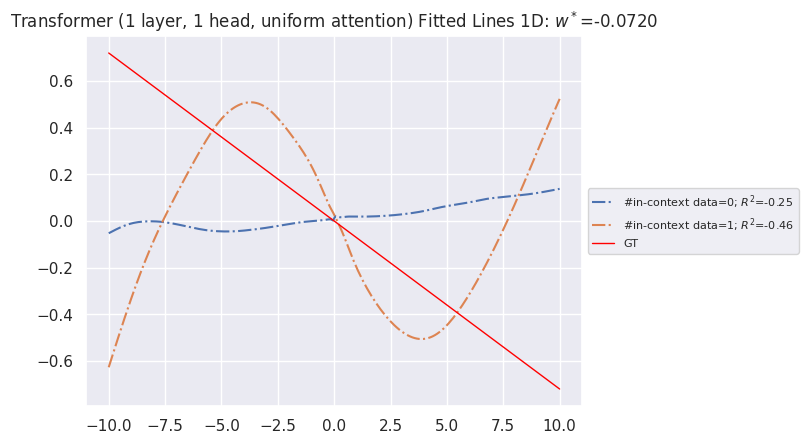

In [35]:
m = 200
x_querys = np.linspace(-10, 10, m)
for i in range(conf.training.curriculum.points.end):
    preds = []
    for x_query in x_querys:
        xs_i = torch.zeros(1, conf.training.curriculum.points.end, 1)
        ys_i = torch.zeros(1, conf.training.curriculum.points.end)
        xs_i[:, :i, :] = xs[:, :i, :]
        xs_i[:, i, :] = x_query
        ys_i[:, :i] = ys[:, :i]
        with torch.no_grad():
            ys_pred_i = model(xs_i, ys_i)
        preds.append(ys_pred_i[:,i].flatten().item())
    r2 = r2_score(x_querys*w_star, preds)
    plt.plot(x_querys, preds, label=f"#in-context data={i}; $R^2$={r2:.2f}", ls="-.")

plt.plot(x_querys, x_querys*w_star, label="GT", lw=1, c="red")
plt.legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim(-5, 5)
plt.title(r"Transformer (1 layer, 1 head, uniform attention) Fitted Lines 1D: $w^*$="+f"{w_star:.4f}")

Text(0.5, 1.0, 'Transformer (1 layer, 1 head, uniform attention) Fitted Lines 1D: $w^*$=-0.0720')

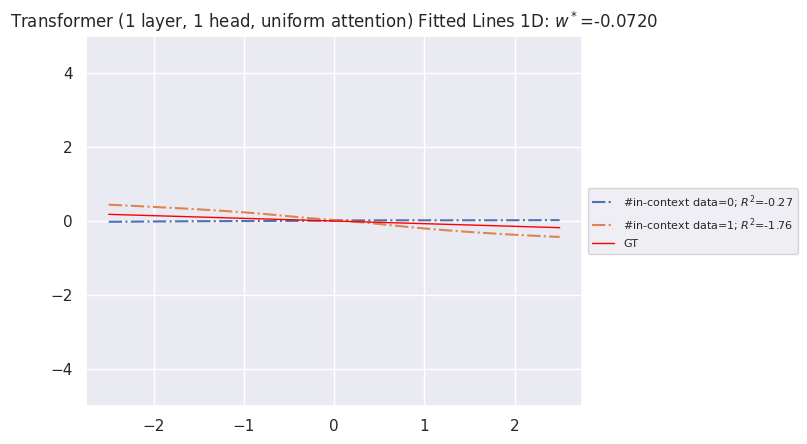

In [36]:
m = 50
x_querys = np.linspace(-2.5, 2.5, m)
for i in range(conf.training.curriculum.points.end):
    preds = []
    for x_query in x_querys:
        xs_i = torch.zeros(1, conf.training.curriculum.points.end, 1)
        ys_i = torch.zeros(1, conf.training.curriculum.points.end)
        xs_i[:, :i, :] = xs[:, :i, :]
        xs_i[:, i, :] = x_query
        ys_i[:, :i] = ys[:, :i]
        with torch.no_grad():
            ys_pred_i = model(xs_i, ys_i)
        preds.append(ys_pred_i[:,i].flatten().item())
    r2 = r2_score(x_querys*w_star, preds)
    plt.plot(x_querys, preds, label=f"#in-context data={i}; $R^2$={r2:.2f}", ls="-.")

plt.plot(x_querys, x_querys*w_star, label="GT", lw=1, c="red")
plt.legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-5, 5)
plt.title(r"Transformer (1 layer, 1 head, uniform attention) Fitted Lines 1D: $w^*$="+f"{w_star:.4f}")

Text(0.5, 1.0, 'residual plot')

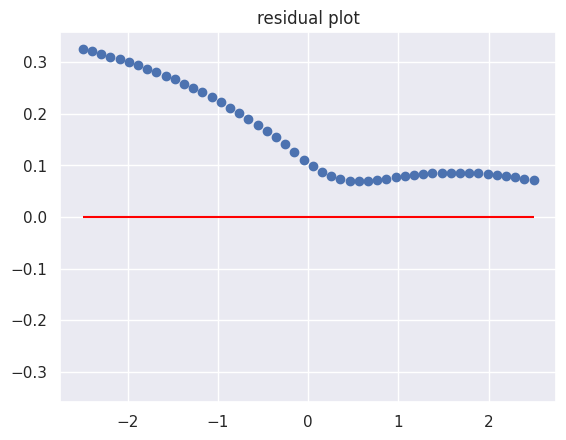

In [21]:
residuals = x_querys*w_star - preds
ylim = max(abs(max(residuals)), abs(min(residuals))) * 1.1
plt.scatter(x_querys, residuals)
plt.hlines(0, xmin=min(x_querys), xmax=max(x_querys), colors='red')
plt.ylim(-ylim, ylim)
plt.title("residual plot")


Text(0.5, 1.0, 'relative error plot')

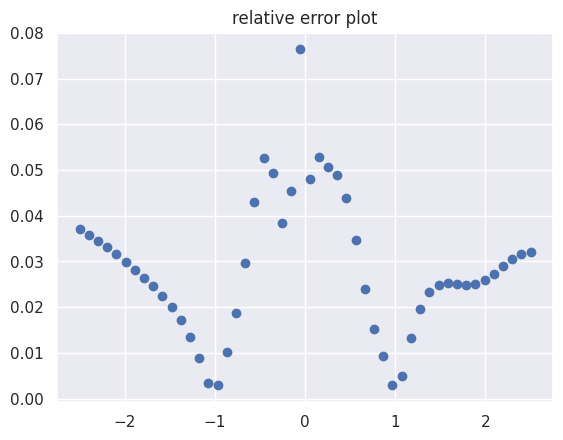

In [10]:
plt.scatter(x_querys, np.abs(residuals/(x_querys*w_star)))
plt.title("relative error plot")

(array([ 4.,  3.,  5.,  7.,  9., 10.,  3.,  3.,  3.,  3.]),
 array([-0.09315896, -0.07309444, -0.05302992, -0.0329654 , -0.01290088,
         0.00716364,  0.02722816,  0.04729269,  0.06735721,  0.08742173,
         0.10748625]),
 <BarContainer object of 10 artists>)

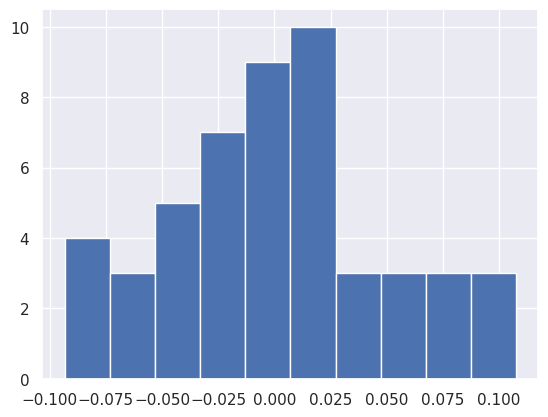

In [11]:
plt.hist(residuals)

In [37]:
def visualize_fitted_line(x0, y0, x_querys):
    w_star = y0/x0  if x0 !=0 else 0.0
    xs = torch.FloatTensor([[[x0], [0]]])
    ys = torch.FloatTensor([[[y0], [0]]])

    
    gt = x_querys*w_star
    preds = []
    for x_query in x_querys:
        xs_i = torch.zeros(1, conf.training.curriculum.points.end, 1)
        ys_i = torch.zeros(1, conf.training.curriculum.points.end)
        xs_i[:, :1, :] = xs[:, :1, :]
        xs_i[:, 1, :] = x_query
        ys_i[:, :1] = ys[:, :1]
        with torch.no_grad():
            ys_pred_i, _ = model(xs_i, ys_i)
        preds.append(ys_pred_i[:,1].flatten().item())
    
    return preds, gt 

def attention(x0, y0, x):
    w = y0/x0 if x0 !=0 else 0.0
    y = w * x 
    xs = torch.FloatTensor([[[x0], [x]]])
    ys = torch.FloatTensor([[[y0], [y]]])
    ys_pred, output = model(xs, ys)
    hmap = output.attentions[0][0].data.cpu().numpy()[0][:3, :3]
    #print(hmap)
    return hmap 

In [38]:
output_dict = {}

num_points = 50
list_x0 = np.linspace(-5, 5, num_points)
list_y0 = np.linspace(-5, 5, num_points)
x_querys = np.linspace(-5, 5, num_points)

model.eval()
model.output_attentions=True
for x0 in tqdm(list_x0):
    for y0 in list_y0:
        pred, gt = visualize_fitted_line(x0, y0, x_querys)
        output_dict[(x0, y0)] = {
            "fitted_line": {
                "pred": pred, 
                "gt": gt
            }, 
            "attention_map": {}
        }
        
        for x in x_querys:
            hmap = attention(x0, y0, x)
            output_dict[(x0, y0)]["attention_map"][x] = hmap 

  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_79094/352545258.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_attention.set_xticklabels(ticklabels, rotation=90, fontsize=8)
/tmp/ipykernel_79094/352545258.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_attention.set_yticklabels(ticklabels, fontsize=8)


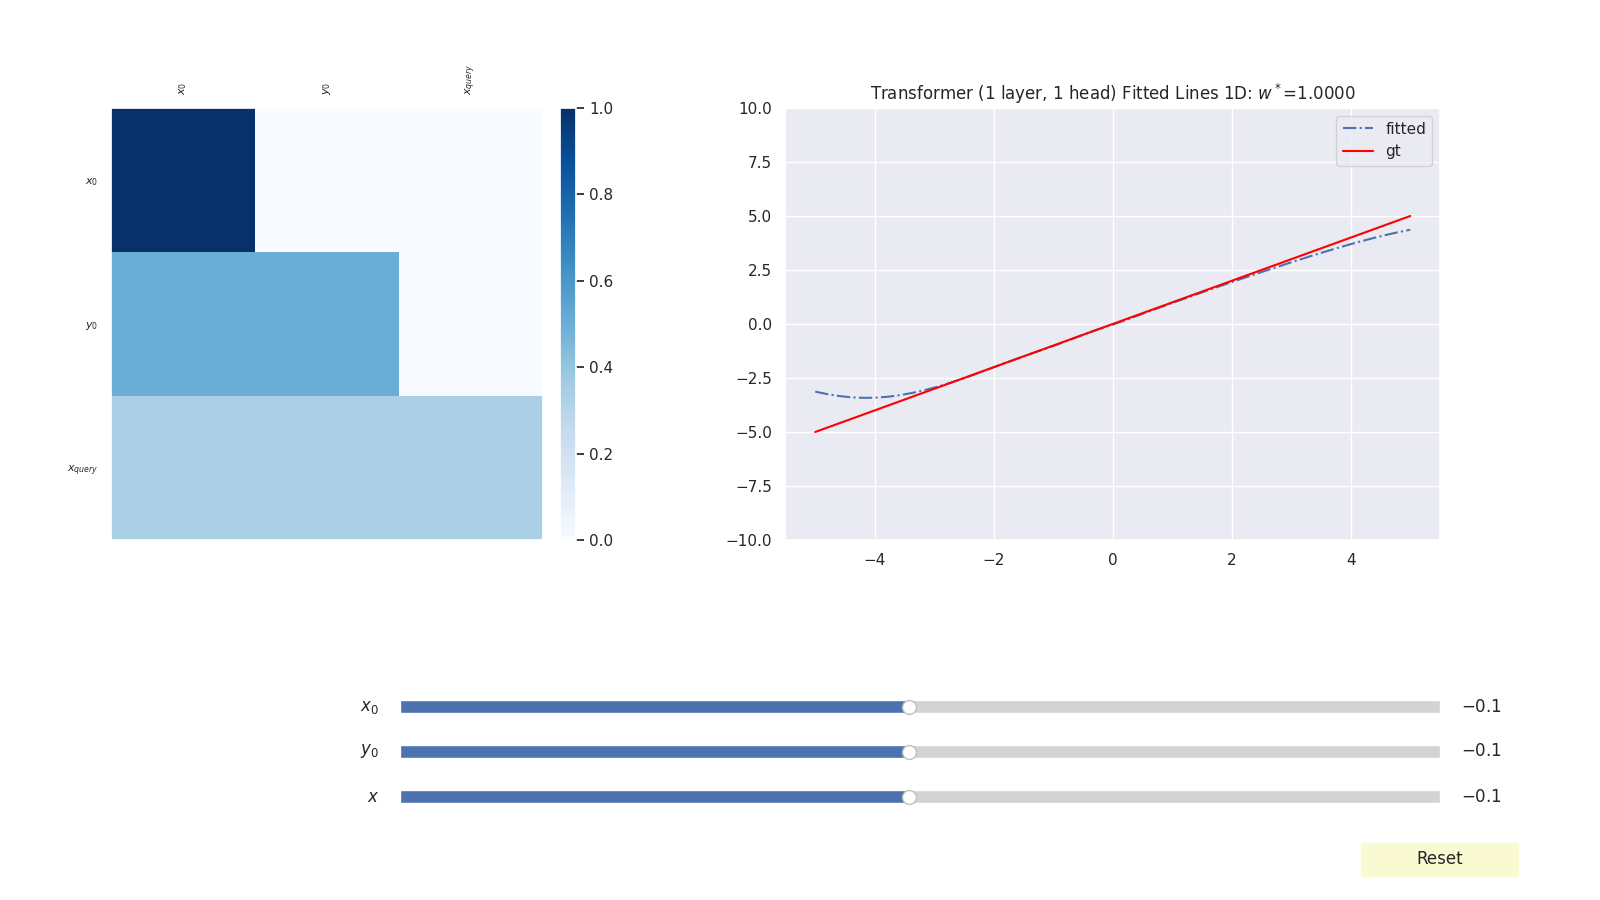

In [39]:
%matplotlib widget
from matplotlib.widgets import Slider, Button, RadioButtons

model.eval()

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

axis_color = 'lightgoldenrodyellow'

fig = plt.figure(figsize=(16, 9))
ax_attention = fig.add_subplot(121)

# Adjust the subplots region to leave some space for the sliders and buttons
fig.subplots_adjust(left=0.0, bottom=0.4)
x0=0
y0=0
x=0

# Draw the initial plot
# The 'line' variable is used for modifying the line later
x0 = find_nearest(list_x0, x0)
y0 = find_nearest(list_y0, y0)
x = find_nearest(x_querys, x)

p = ax_attention.matshow(output_dict[(x0, y0)]["attention_map"][x], cmap='Blues')
ticklabels = ['', f'$x_0$', f'$y_0$', r'$x_{query}$']
ax_attention.set_xticklabels(ticklabels, rotation=90, fontsize=8)
ax_attention.set_yticklabels(ticklabels, fontsize=8)
ax_attention.grid([])
ax_attention.tick_params(bottom=False, top=False)    
cax = fig.add_axes([0.35, 0.4, 0.01, 0.48])
fig.colorbar(p, cax=cax, orientation='vertical')


ax_fitted_line = fig.add_subplot(122)
#fig.subplots_adjust(left=0.75, bottom=0.25)
y_pred = output_dict[(x0, y0)]["fitted_line"]["pred"]
y_gt = output_dict[(x0, y0)]["fitted_line"]["gt"]
[p_pred] = ax_fitted_line.plot(x_querys, y_pred, ls='-.', label='fitted')
[p_gt] = ax_fitted_line.plot(x_querys, y_gt, c='red', label='gt')
ax_fitted_line.set_ylim(-10,10)
ax_fitted_line.legend()
w_star = y0/x0
ax_fitted_line.set_title(r"Transformer (1 layer, 1 head) Fitted Lines 1D: $w^*$="+f"{w_star:.4f}")

# Add two sliders for tweaking the parameters

# Define an axes area and draw a slider in it
x0_slider_ax  = fig.add_axes([0.25, 0.2, 0.65, 0.03], facecolor=axis_color)
x0_slider = Slider(x0_slider_ax, r'$x_0$', -5.0, 5.0, valinit=x0)
#x0_slider_ax.add_artist(x0_slider_ax.xaxis)
#sl_xticks = np.arange(-5, 5, 0.5)
#x0_slider_ax.set_xticks(sl_xticks)


# Draw another slider
y0_slider_ax = fig.add_axes([0.25, 0.15, 0.65, 0.03], facecolor=axis_color)
y0_slider = Slider(y0_slider_ax, r'$y_0$', -5.0, 5.0, valinit=y0)
#y0_slider_ax.add_artist(y0_slider_ax.xaxis)
#sl_xticks = np.arange(-5, 5, 0.5)
#y0_slider_ax.set_xticks(sl_xticks)

x_slider_ax  = fig.add_axes([0.25, 0.1, 0.65, 0.03], facecolor=axis_color)
x_slider = Slider(x_slider_ax, r'$x$', -5.0, 5.0, valinit=x)
#x_slider_ax.add_artist(x_slider_ax.xaxis)
#sl_xticks = np.arange(-5, 5, 0.5)
#x_slider_ax.set_xticks(sl_xticks)

# Define an action for modifying the line when any slider's value changes
def sliders_on_changed(val):
    x0 = find_nearest(list_x0, x0_slider.val)
    y0 = find_nearest(list_y0, y0_slider.val)
    x = find_nearest(x_querys, x_slider.val)
    p.set_data(output_dict[(x0, y0)]["attention_map"][x])

    y_pred = output_dict[(x0, y0)]["fitted_line"]["pred"]
    y_gt = output_dict[(x0, y0)]["fitted_line"]["gt"]
    p_pred.set_ydata(y_pred)
    p_gt.set_ydata(y_gt)
    w_star = y0/x0
    ax_fitted_line.set_title(r"Transformer (1 layer, 1 head) Fitted Lines 1D: $w^*$="+f"{w_star:.4f}")

    fig.canvas.draw_idle()

x0_slider.on_changed(sliders_on_changed)
y0_slider.on_changed(sliders_on_changed)
x_slider.on_changed(sliders_on_changed)

# Add a button for resetting the parameters
reset_button_ax = fig.add_axes([0.85, 0.025, 0.1, 0.04])
reset_button = Button(reset_button_ax, 'Reset', color=axis_color, hovercolor='0.975')

def reset_button_on_clicked(mouse_event):
    x0_slider.reset()
    y0_slider.reset()
    x.slider.reset()
reset_button.on_clicked(reset_button_on_clicked)

plt.suptitle("")
plt.show()

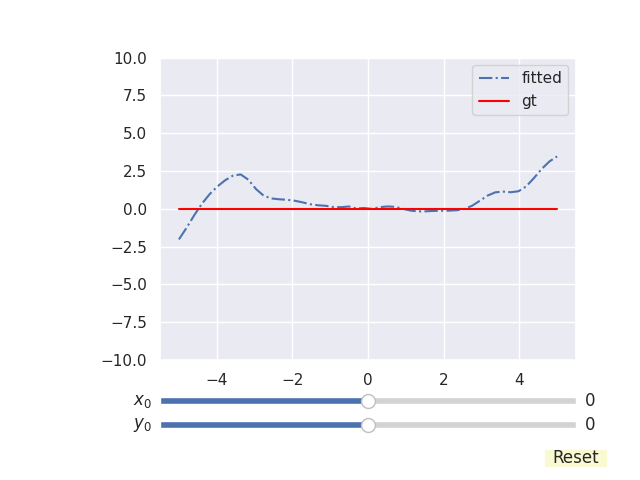

In [13]:
%matplotlib widget
from matplotlib.widgets import Slider, Button

model.eval()
model.output_attentions=False
m = 50
x_querys = np.linspace(-5, 5, m)

def visualize_fitted_line(x0, y0):
    w_star = y0/x0  if x0 !=0 else 0.0
    xs = torch.FloatTensor([[[x0], [0]]])
    ys = torch.FloatTensor([[[y0], [0]]])

    
    gt = x_querys*w_star
    preds = []
    for x_query in x_querys:
        xs_i = torch.zeros(1, conf.training.curriculum.points.end, 1)
        ys_i = torch.zeros(1, conf.training.curriculum.points.end)
        xs_i[:, :1, :] = xs[:, :1, :]
        xs_i[:, 1, :] = x_query
        ys_i[:, :1] = ys[:, :1]
        with torch.no_grad():
            ys_pred_i = model(xs_i, ys_i)
        preds.append(ys_pred_i[:,1].flatten().item())
    
    return preds, gt 
        
axis_color = 'lightgoldenrodyellow'

fig = plt.figure()
ax = fig.add_subplot(111)

# Adjust the subplots region to leave some space for the sliders and buttons
fig.subplots_adjust(left=0.25, bottom=0.25)
x0=0
y0=0

# Draw the initial plot
# The 'line' variable is used for modifying the line later
y_pred, y_gt = visualize_fitted_line(x0, y0)
[p_pred] = ax.plot(x_querys, y_pred, ls='-.', label='fitted')
[p_gt] = ax.plot(x_querys, y_gt, c='red', label='gt')
ax.set_ylim(-10,10)
ax.legend()

# Add two sliders for tweaking the parameters

# Define an axes area and draw a slider in it
x0_slider_ax  = fig.add_axes([0.25, 0.15, 0.65, 0.03], facecolor=axis_color)
x0_slider = Slider(x0_slider_ax, r'$x_0$', -5.0, 5.0, valinit=x0)

# Draw another slider
y0_slider_ax = fig.add_axes([0.25, 0.1, 0.65, 0.03], facecolor=axis_color)
y0_slider = Slider(y0_slider_ax, r'$y_0$', -5.0, 5.0, valinit=y0)


# Define an action for modifying the line when any slider's value changes
def sliders_on_changed(val):
    y_pred, y_gt = visualize_fitted_line(x0_slider.val, y0_slider.val)
    p_pred.set_ydata(y_pred)
    p_gt.set_ydata(y_gt)
    fig.canvas.draw_idle()

x0_slider.on_changed(sliders_on_changed)
y0_slider.on_changed(sliders_on_changed)

# Add a button for resetting the parameters
reset_button_ax = fig.add_axes([0.85, 0.025, 0.1, 0.04])
reset_button = Button(reset_button_ax, 'Reset', color=axis_color, hovercolor='0.975')

def reset_button_on_clicked(mouse_event):
    x0_slider.reset()
    y0_slider.reset()
reset_button.on_clicked(reset_button_on_clicked)

plt.show()

# Visualizing Attention

In [9]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
model.eval()
model.output_attentions=True

In [28]:
xs.shape

torch.Size([1, 2, 1])

In [29]:
ys_pred, output = model(xs, ys)

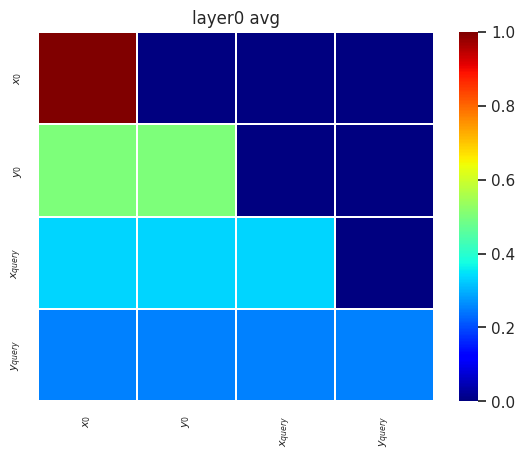

In [30]:
n_data = 1
pad_cls = 0
for layer in range(conf.model['n_layer']):
    g = sn.heatmap(output.attentions[layer][0].mean(axis=0).data.cpu().numpy()[0:n_data*2+2,0:n_data*2+2], \
                   xticklabels=True, yticklabels=True, linecolor='white', linewidths=0.1, cmap='jet')
    ticklabels = np.array([[f'$x_{{{i}}}$', f'$y_{{{i}}}$'] for i in range(0, n_data)]).flatten().tolist() + [r'$x_{query}$', r'$y_{query}$']
    if pad_cls == 1: ticklabels = ['[CLS]'] + ticklabels
    g.set_xticklabels(ticklabels, rotation=90, fontsize=8)
    g.set_yticklabels(ticklabels, fontsize=8)
    
    folder = f"/home/deqingfu/in-context-learning/attentions_1d_tiny/layer{layer}/"
    if not os.path.exists(folder):
        os.makedirs(folder)
    #plt.savefig(folder + f"{layer}.png", \
    #            bbox_inches='tight', pad_inches=0.1, dpi=500)
    #plt.clf()
    plt.title(f"layer{layer} avg")
    plt.show()
    plt.close()

In [33]:
xs

tensor([[[ 1.0223],
         [-1.3961]]])

/tmp/ipykernel_62166/2643804228.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticklabels, rotation=90, fontsize=8)
/tmp/ipykernel_62166/2643804228.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticklabels, fontsize=8)


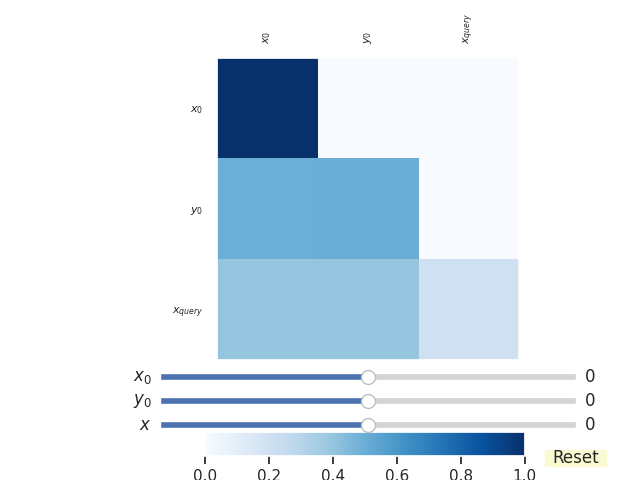

In [7]:
%matplotlib widget
from matplotlib.widgets import Slider, Button, RadioButtons

model.eval()
model.output_attentions=True

def attention(x0, y0, x):
    w = y0/x0 if x0 !=0 else 0.0
    y = w * x 
    xs = torch.FloatTensor([[[x0], [x]]])
    ys = torch.FloatTensor([[[y0], [y]]])
    ys_pred, output = model(xs, ys)
    hmap = output.attentions[0][0].data.cpu().numpy()[0][:3, :3]
    #print(hmap)
    return hmap 

axis_color = 'lightgoldenrodyellow'

fig = plt.figure()
ax = fig.add_subplot(111)

# Adjust the subplots region to leave some space for the sliders and buttons
fig.subplots_adjust(left=0.25, bottom=0.25)
x0=0
y0=0
x=0

# Draw the initial plot
# The 'line' variable is used for modifying the line later
p = ax.matshow(attention(x0, y0, x), cmap='Blues')
ticklabels = ['', f'$x_0$', f'$y_0$', r'$x_{query}$']
ax.set_xticklabels(ticklabels, rotation=90, fontsize=8)
ax.set_yticklabels(ticklabels, fontsize=8)
ax.grid([])
ax.tick_params(bottom=False, top=False)    
cax = fig.add_axes([0.32, 0.05, 0.5, 0.05])
fig.colorbar(p, cax=cax, orientation='horizontal')


# Add two sliders for tweaking the parameters

# Define an axes area and draw a slider in it
x0_slider_ax  = fig.add_axes([0.25, 0.2, 0.65, 0.03], facecolor=axis_color)
x0_slider = Slider(x0_slider_ax, r'$x_0$', -5.0, 5.0, valinit=x0)

# Draw another slider
y0_slider_ax = fig.add_axes([0.25, 0.15, 0.65, 0.03], facecolor=axis_color)
y0_slider = Slider(y0_slider_ax, r'$y_0$', -5.0, 5.0, valinit=y0)

x_slider_ax  = fig.add_axes([0.25, 0.1, 0.65, 0.03], facecolor=axis_color)
x_slider = Slider(x_slider_ax, r'$x$', -5.0, 5.0, valinit=x)

# Define an action for modifying the line when any slider's value changes
def sliders_on_changed(val):
    p.set_data(attention(x0_slider.val, y0_slider.val, x_slider.val))
    fig.canvas.draw_idle()

x0_slider.on_changed(sliders_on_changed)
y0_slider.on_changed(sliders_on_changed)
x_slider.on_changed(sliders_on_changed)

# Add a button for resetting the parameters
reset_button_ax = fig.add_axes([0.85, 0.025, 0.1, 0.04])
reset_button = Button(reset_button_ax, 'Reset', color=axis_color, hovercolor='0.975')

def reset_button_on_clicked(mouse_event):
    x0_slider.reset()
    y0_slider.reset()
    x.slider.reset()
reset_button.on_clicked(reset_button_on_clicked)

plt.show()

# Comparison with Least Square

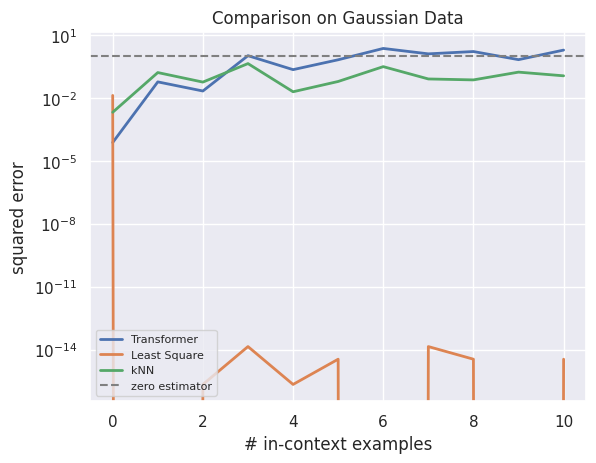

In [20]:
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.model.n_positions)
ys = task.evaluate(xs)
with torch.no_grad():
    try:
        ys_pred = model(xs, ys)
    except:
        ys_pred, _ = model(xs, ys)

metric = task.get_metric()
loss_gau = metric(ys_pred, ys)

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss_gau.mean(axis=0), lw=2, label="Transformer")

lstsq_model = models.LeastSquaresModel()
lstsq_gau = aggregate_metrics(eval_batch(lstsq_model, task_sampler, xs))['mean']
plt.plot(lstsq_gau, lw=2, label=f"Least Square")

knn_model = models.NNModel(n_neighbors=10)
knn_gau = aggregate_metrics(eval_batch(knn_model, task_sampler, xs))['mean']
plt.plot(knn_gau, lw=2, label=f"kNN")

plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.title("Comparison on Gaussian Data")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.yscale("log")
plt.legend(loc="lower left", fontsize=8)
plt.show()

In [241]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])
num_params

6634625

# Extracting Parameters

In [75]:
%matplotlib inline

In [76]:
embed_dim = model._backbone.h[0].attn.embed_dim

In [77]:
W_Q, W_K, W_V = model._backbone.h[0].attn.c_attn.weight.reshape(embed_dim,-1,embed_dim).permute((1, 0, 2))
W_E = model._read_in.weight
W_P = model._backbone.h[0].attn.c_proj.weight
W_O = model._read_out.weight

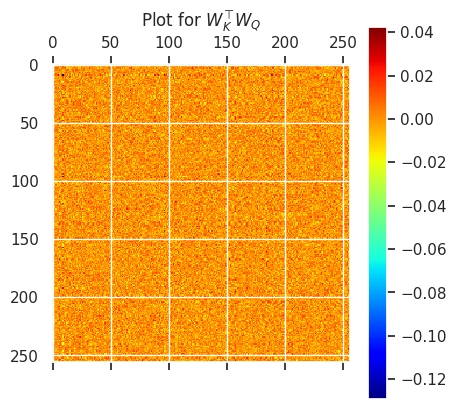

In [78]:
plt.matshow((W_K.T @ W_Q).detach().numpy(), cmap='jet')
plt.colorbar()
plt.title(r'Plot for $W_K^\top W_Q$')
plt.show()

In [79]:
_, s, _ = np.linalg.svd((W_K.T @ W_Q).detach().numpy())

<BarContainer object of 256 artists>

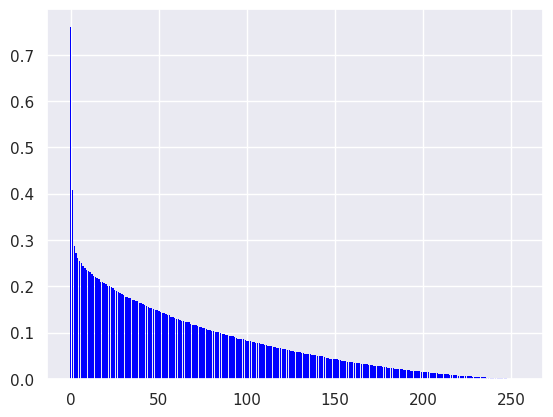

In [91]:
plt.bar(range(len(s)), s, color='blue', edgecolor='None')

In [245]:
p0 = model._backbone.wpe(torch.LongTensor([0])).T
p1 = model._backbone.wpe(torch.LongTensor([1])).T
p2 = model._backbone.wpe(torch.LongTensor([2])).T

In [246]:
C = W_E.T @ W_K.T @ W_Q @ W_E 
C

tensor([[-0.0066]], grad_fn=<MmBackward0>)

In [247]:
W_E.T @ W_K.T @ W_Q @ p2

tensor([[-0.1223]], grad_fn=<MmBackward0>)

In [250]:
p2.T @ W_K.T @ W_Q @ W_E 

tensor([[-0.2949]], grad_fn=<MmBackward0>)

In [56]:
p0.shape

torch.Size([1, 256])

In [253]:
p2.T @ W_K.T @ W_Q @ p2

tensor([[-0.1004]], grad_fn=<MmBackward0>)

In [20]:
d = {}
d["pool_dict"] = {
    "w": np.linspace(-3, 3, 10).tolist()
}

In [21]:
d

{'pool_dict': {'w': [-3.0,
   -2.3333333333333335,
   -1.6666666666666667,
   -1.0,
   -0.3333333333333335,
   0.33333333333333304,
   1.0,
   1.666666666666666,
   2.333333333333333,
   3.0]}}

In [9]:
import yaml

with open('./conf/models/fixed.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    fruits_list = yaml.load(file, Loader=yaml.FullLoader)

    print(fruits_list)

{'model': {'family': 'gpt2', 'n_embd': 256, 'n_layer': 1, 'n_head': 1}, 'training': {'task_kwargs': {'pool_dict': {'w': [-3.0, -2.993993993993994, -2.987987987987988, -2.981981981981982, -2.975975975975976, -2.96996996996997, -2.963963963963964, -2.957957957957958, -2.951951951951952, -2.945945945945946, -2.93993993993994, -2.933933933933934, -2.9279279279279278, -2.921921921921922, -2.915915915915916, -2.90990990990991, -2.903903903903904, -2.8978978978978978, -2.891891891891892, -2.885885885885886, -2.87987987987988, -2.873873873873874, -2.8678678678678677, -2.861861861861862, -2.855855855855856, -2.84984984984985, -2.843843843843844, -2.8378378378378377, -2.831831831831832, -2.825825825825826, -2.81981981981982, -2.813813813813814, -2.8078078078078077, -2.8018018018018016, -2.795795795795796, -2.78978978978979, -2.7837837837837838, -2.7777777777777777, -2.7717717717717716, -2.765765765765766, -2.75975975975976, -2.7537537537537538, -2.7477477477477477, -2.7417417417417416, -2.735735